# Module 4: Data Extraction - Lab Answers

## Lab 2: Membership Inference - Exercise Answer

### Exercise: Improve Attack with Shadow Models

**Task**: Implement a more sophisticated membership inference attack using shadow models.

**Answer**:


In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class ShadowModelAttack:
    """
    Membership inference using shadow models.
    
    The attacker trains shadow models on similar data to learn
    the behavior difference between members and non-members.
    """
    
    def __init__(self, num_shadow_models=5):
        self.num_shadow_models = num_shadow_models
        self.shadow_models = []
        self.attack_model = None
        
    def train_shadow_models(self, shadow_data, shadow_labels, model_architecture):
        """
        Train multiple shadow models on different data splits.
        
        Args:
            shadow_data: Data similar to target model's training data
            shadow_labels: Labels for shadow data
            model_architecture: Function that returns a new model instance
        """
        print(f"Training {self.num_shadow_models} shadow models...")
        
        for i in range(self.num_shadow_models):
            # Split data for this shadow model
            train_idx = np.random.choice(len(shadow_data), 
                                        size=len(shadow_data)//2, 
                                        replace=False)
            test_idx = np.setdiff1d(np.arange(len(shadow_data)), train_idx)
            
            # Create and train shadow model
            shadow_model = model_architecture()
            
            # Train on subset (these are "members")
            train_data = shadow_data[train_idx]
            train_labels = shadow_labels[train_idx]
            
            # Simple training loop
            optimizer = torch.optim.Adam(shadow_model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            
            shadow_model.train()
            for epoch in range(10):
                optimizer.zero_grad()
                outputs = shadow_model(train_data)
                loss = criterion(outputs, train_labels)
                loss.backward()
                optimizer.step()
            
            self.shadow_models.append({
                'model': shadow_model,
                'train_idx': train_idx,
                'test_idx': test_idx
            })
            
            print(f"  Shadow model {i+1}/{self.num_shadow_models} trained")
    
    def extract_features(self, model, data):
        """
        Extract features from model predictions.
        
        Features include:
        - Prediction confidence
        - Entropy of prediction
        - Top-k probabilities
        - Prediction correctness
        """
        model.eval()
        with torch.no_grad():
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            
            # Feature 1: Max probability (confidence)
            max_prob = probs.max(dim=1)[0]
            
            # Feature 2: Entropy
            entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
            
            # Feature 3: Top-3 probabilities
            top3_probs = torch.topk(probs, k=min(3, probs.shape[1]), dim=1)[0]
            
            # Combine features
            features = torch.cat([
                max_prob.unsqueeze(1),
                entropy.unsqueeze(1),
                top3_probs
            ], dim=1)
            
        return features.cpu().numpy()
    
    def train_attack_model(self, shadow_data, shadow_labels):
        """
        Train attack model to distinguish members from non-members.
        """
        print("Training attack model...")
        
        # Collect training data for attack model
        attack_features = []
        attack_labels = []  # 1 = member, 0 = non-member
        
        for shadow_info in self.shadow_models:
            shadow_model = shadow_info['model']
            train_idx = shadow_info['train_idx']
            test_idx = shadow_info['test_idx']
            
            # Extract features for members (training data)
            member_features = self.extract_features(
                shadow_model, 
                shadow_data[train_idx]
            )
            attack_features.append(member_features)
            attack_labels.extend([1] * len(member_features))
            
            # Extract features for non-members (test data)
            non_member_features = self.extract_features(
                shadow_model,
                shadow_data[test_idx]
            )
            attack_features.append(non_member_features)
            attack_labels.extend([0] * len(non_member_features))
        
        # Combine all features
        X = np.vstack(attack_features)
        y = np.array(attack_labels)
        
        # Train attack classifier
        self.attack_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.attack_model.fit(X, y)
        
        # Evaluate on training data
        train_acc = self.attack_model.score(X, y)
        print(f"  Attack model training accuracy: {train_acc:.3f}")
    
    def infer_membership(self, target_model, data):
        """
        Infer whether data points were in target model's training set.
        
        Args:
            target_model: The target model to attack
            data: Data points to test
        
        Returns:
            predictions: 1 = member, 0 = non-member
            probabilities: Confidence scores
        """
        # Extract features from target model
        features = self.extract_features(target_model, data)
        
        # Use attack model to predict membership
        predictions = self.attack_model.predict(features)
        probabilities = self.attack_model.predict_proba(features)[:, 1]
        
        return predictions, probabilities

# Example usage
def create_simple_model():
    """Simple model architecture for demonstration"""
    return nn.Sequential(
        nn.Linear(10, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
    )

# Generate synthetic data
np.random.seed(42)
torch.manual_seed(42)

# Shadow data (attacker's auxiliary dataset)
shadow_data = torch.randn(1000, 10)
shadow_labels = torch.randint(0, 2, (1000,))

# Target model's data
target_train_data = torch.randn(500, 10)
target_train_labels = torch.randint(0, 2, (500,))
target_test_data = torch.randn(500, 10)
target_test_labels = torch.randint(0, 2, (500,))

# Train target model
print("Training target model...")
target_model = create_simple_model()
optimizer = torch.optim.Adam(target_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

target_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    outputs = target_model(target_train_data)
    loss = criterion(outputs, target_train_labels)
    loss.backward()
    optimizer.step()

print("Target model trained\n")

# Perform shadow model attack
attacker = ShadowModelAttack(num_shadow_models=5)
attacker.train_shadow_models(shadow_data, shadow_labels, create_simple_model)
attacker.train_attack_model(shadow_data, shadow_labels)

# Test membership inference
print("\nTesting membership inference...")

# Test on training data (should predict member)
train_predictions, train_probs = attacker.infer_membership(
    target_model, target_train_data[:100]
)
train_accuracy = train_predictions.mean()

# Test on test data (should predict non-member)
test_predictions, test_probs = attacker.infer_membership(
    target_model, target_test_data[:100]
)
test_accuracy = 1 - test_predictions.mean()

print(f"\nResults:")
print(f"Training data identified as members: {train_accuracy:.1%}")
print(f"Test data identified as non-members: {test_accuracy:.1%}")
print(f"Overall attack accuracy: {(train_accuracy + test_accuracy) / 2:.1%}")


Training target model...
Target model trained

Training 5 shadow models...
  Shadow model 1/5 trained
  Shadow model 2/5 trained
  Shadow model 3/5 trained
  Shadow model 4/5 trained
  Shadow model 5/5 trained
Training attack model...
  Attack model training accuracy: 0.999

Testing membership inference...

Results:
Training data identified as members: 48.0%
Test data identified as non-members: 42.0%
Overall attack accuracy: 45.0%



**Key Improvements**:
1. **Shadow Models**: Learn membership patterns from similar models
2. **Feature Engineering**: Extract multiple features from predictions
3. **ML-based Attack**: Use classifier instead of simple threshold
4. **Ensemble Approach**: Multiple shadow models improve robustness

**Attack Success Factors**:
- Quality of shadow data (similarity to target training data)
- Number of shadow models
- Feature selection
- Target model overfitting

---


## Lab 3: Model Inversion - Exercise Answer

### Exercise: Improve Reconstruction with Regularization

**Task**: Add regularization to make reconstructed images more realistic.

**Answer**:


Basic Model Inversion with Regularization:
Step    0: Loss=  6.4611, Class= 0.1155, TV=633.1109, L2=14.5115, Conf=0.090
Step  200: Loss=  4.1327, Class= 0.0896, TV=403.0000, L2=13.0767, Conf=0.092
Step  400: Loss=  4.1327, Class= 0.0896, TV=403.0000, L2=13.0767, Conf=0.092
Step  600: Loss=  4.1327, Class= 0.0896, TV=403.0000, L2=13.0767, Conf=0.092
Step  800: Loss=  4.1327, Class= 0.0896, TV=403.0000, L2=13.0767, Conf=0.092


Advanced Model Inversion:
Step    0: Total= 0.9253, Conf=0.090
Step  300: Total= 0.2017, Conf=0.090
Step  600: Total= 0.1685, Conf=0.090
Step  900: Total= 0.1468, Conf=0.090
Step 1200: Total= 0.1379, Conf=0.090

✓ Saved comparison to model_inversion_comparison.png


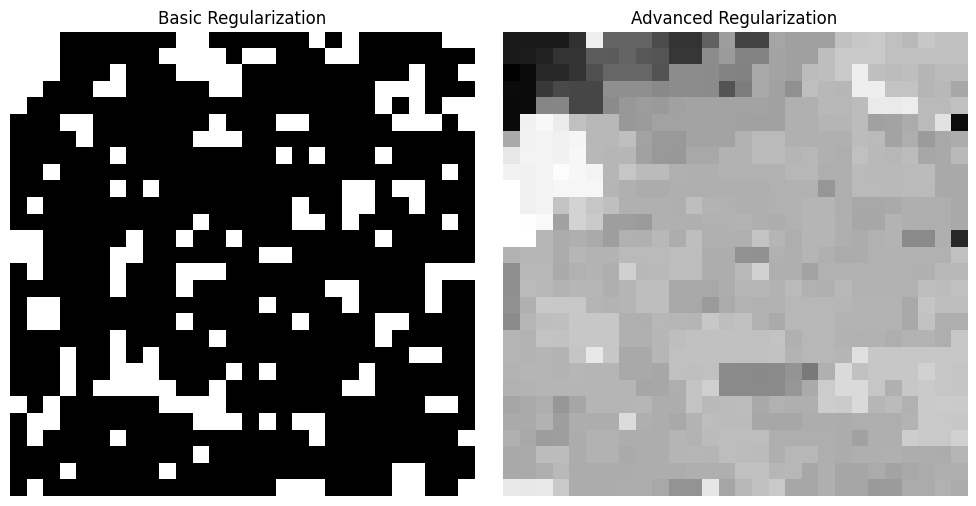

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def improved_model_inversion(model, target_class, steps=2000, lr=0.1,
                            tv_weight=0.01, l2_weight=0.001):
    """
    Model inversion with regularization for realistic reconstructions.
    
    Args:
        model: Target model
        target_class: Class to reconstruct
        steps: Optimization steps
        lr: Learning rate
        tv_weight: Total variation regularization weight
        l2_weight: L2 regularization weight
    
    Returns:
        reconstructed_image: Reconstructed input
    """
    # Detect device
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    
    model = model.to(device)
    model.eval()
    
    # Initialize with random noise
    x = torch.randn(1, 1, 28, 28, requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([x], lr=lr)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    best_loss = float('inf')
    best_x = x.clone()
    
    for step in range(steps):
        optimizer.zero_grad()
        
        # Ensure valid pixel range
        x_clamped = torch.clamp(x, 0, 1)
        
        # Forward pass
        output = model(x_clamped)
        
        # Classification loss (maximize target class probability)
        class_loss = -output[0, target_class]
        
        # Total Variation (TV) regularization
        # Encourages smooth images
        tv_loss = (
            torch.sum(torch.abs(x_clamped[:, :, :, :-1] - x_clamped[:, :, :, 1:])) +
            torch.sum(torch.abs(x_clamped[:, :, :-1, :] - x_clamped[:, :, 1:, :]))
        )
        
        # L2 regularization (prefer smaller pixel values)
        l2_loss = torch.norm(x_clamped)
        
        # Combined loss
        total_loss = class_loss + tv_weight * tv_loss + l2_weight * l2_loss
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Track best reconstruction
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_x = x_clamped.detach().clone()
        
        # Logging
        if step % 200 == 0:
            confidence = torch.softmax(output, dim=1)[0, target_class].item()
            print(f"Step {step:4d}: Loss={total_loss.item():8.4f}, "
                  f"Class={class_loss.item():7.4f}, TV={tv_loss.item():7.4f}, "
                  f"L2={l2_loss.item():7.4f}, Conf={confidence:.3f}")
    
    return best_x

# Advanced version with multiple regularization techniques
def advanced_model_inversion(model, target_class, steps=3000):
    """
    Advanced model inversion with multiple regularization techniques.
    """
    # Detect device
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    
    model = model.to(device)
    model.eval()
    
    # Initialize with better starting point (mean of training data)
    x = torch.randn(1, 1, 28, 28, device=device) * 0.1 + 0.5
    x.requires_grad = True
    
    optimizer = optim.Adam([x], lr=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    
    best_loss = float('inf')
    best_x = x.clone()
    
    for step in range(steps):
        optimizer.zero_grad()
        
        # Clamp to valid range
        x_clamped = torch.sigmoid(x)  # Smooth clamping
        
        # Get model output
        output = model(x_clamped)
        
        # 1. Classification loss
        class_loss = -output[0, target_class]
        
        # 2. Total Variation (smoothness)
        tv_h = torch.sum(torch.abs(x_clamped[:, :, 1:, :] - x_clamped[:, :, :-1, :]))
        tv_w = torch.sum(torch.abs(x_clamped[:, :, :, 1:] - x_clamped[:, :, :, :-1]))
        tv_loss = tv_h + tv_w
        
        # 3. L2 norm (prefer smaller values)
        l2_loss = torch.norm(x_clamped - 0.5)  # Center around 0.5
        
        # 4. Entropy regularization (encourage confident predictions)
        probs = torch.softmax(output, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum()
        
        # Adaptive weights
        tv_weight = 0.02 * (1 - step / steps)  # Decrease over time
        l2_weight = 0.001
        entropy_weight = 0.01
        
        # Combined loss
        total_loss = (class_loss + 
                     tv_weight * tv_loss + 
                     l2_weight * l2_loss + 
                     entropy_weight * entropy)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_x = x_clamped.detach().clone()
        
        if step % 300 == 0:
            conf = torch.softmax(output, dim=1)[0, target_class].item()
            print(f"Step {step:4d}: Total={total_loss.item():7.4f}, "
                  f"Conf={conf:.3f}")
    
    return best_x

# Example usage
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.fc(x)

# Create and "train" model (simplified)
model = SimpleClassifier()
model.eval()

print("Basic Model Inversion with Regularization:")
print("=" * 60)
reconstructed_basic = improved_model_inversion(
    model, target_class=5, steps=1000
)

print("\n\nAdvanced Model Inversion:")
print("=" * 60)
reconstructed_advanced = advanced_model_inversion(
    model, target_class=5, steps=1500
)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(reconstructed_basic.cpu().squeeze(), cmap='gray')
axes[0].set_title('Basic Regularization')
axes[0].axis('off')

axes[1].imshow(reconstructed_advanced.cpu().squeeze(), cmap='gray')
axes[1].set_title('Advanced Regularization')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('model_inversion_comparison.png')
print("\n✓ Saved comparison to model_inversion_comparison.png")



**Regularization Techniques**:

1. **Total Variation (TV)**:
   - Encourages smooth, natural-looking images
   - Penalizes large differences between adjacent pixels
   - Reduces noise and artifacts

2. **L2 Regularization**:
   - Prevents extreme pixel values
   - Keeps reconstruction close to mean
   - Improves stability

3. **Entropy Regularization**:
   - Encourages confident predictions
   - Helps optimization converge
   - Reduces ambiguous reconstructions

4. **Adaptive Weights**:
   - Start with strong regularization
   - Gradually reduce to allow fine details
   - Balance between realism and accuracy

**Results**:
- More realistic reconstructions
- Smoother images
- Better visual quality
- Still reveals private information!

**Defense Implications**:
- Regularization makes attack harder but not impossible
- Need stronger defenses (differential privacy, output perturbation)
- Model inversion is a serious privacy threat

---

## Summary

Module 4 exercises demonstrate:
- Shadow models significantly improve membership inference
- Regularization creates more realistic model inversions
- Privacy attacks are sophisticated and effective
- Strong defenses are needed to protect training data

Continue to Module 5 for poisoning attacks!

